# Time Series Clustering with Topological Data Analysis

_Created by:_ Philipp Weiler and Lewis Tunstall, December 2019.

_Blog post:_ https://towardsdatascience.com/the-shape-of-population-dynamics-ba70f253919f


This notebook explores the application of topological data analysis (TDA) for time series clustering. We partially follow ideas presented in a paper by <a href="https://www.sciencedirect.com/science/article/pii/S0957417415002407">Pereira and de Mello</a> in  2015.
The TDA features are extracted with the help of <a href="https://giotto.ai">gitto-learn</a>, an open-source Python library designed for integrating TDA within the <a href="https://scikit-learn.org/stable/sklearn">scikit-learn</a> framework.

## Beetle dynamics
Here, we aim to cluster two different time series that describe the population of the [_Tribolium_ flour beetle](https://en.wikipedia.org/wiki/Red_flour_beetle). The beetle's life cycle consists of larva, pupa, and adult stages, with the transition between each stage lasting two weeks. Following <a href="https://www.nature.com/articles/375227a0">Costantino, Cushing, Dennis and Desharnais</a>, we can describe the dynamics of the beetle population using the following difference equation:

$$
\begin{equation}
    \begin{aligned}
        L_{t + 1} &= b A_t e^{E_{1, t} -c_{ea} A_t - c_{el} L_t}\\
        P_{t + 1} &= L_t (1 - \mu_l) e^{E_{2, t}}\\
        A_{t + 1} &= [P_t e^{-c_{pa} A_t} + A_t (1 - \mu_a)]e^{E_{3, t}}
    \end{aligned}
    \tag{1}
    \label{eq: BeetleEq}
\end{equation}
$$

Here, $L_t, P_t$ and $A_t$ denote the number of larvae, pupae and adults at time $t$, while $\mu_l$ and $\mu_a$ denote the fraction of larvae and pupae that dies. _Tribolium_ flour beetles become cold-hearted in face of overpopulation as they turn cannibalistic by eating unhatched eggs and pupae. This behaviour was modeled probabilistcally with the terms $exp(-c_{ea}A_t)$ and $exp(-c_{el}L_t)$. The probability of surviving this massacre from pupa to adult stage is given by $exp(-c_{pa}A_t)$. To incorporate for example environmental uncertainty, we include multivariate normally distributed noise $E_{1, t}, E_{2, t}$ and $E_{3, t}$ with mean zero and common standard deviation $\sigma$.

# Import libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
# data wrangling
import pandas as pd
import numpy as np
from fastprogress import progress_bar
from pathlib import Path
from beetles_tda.generate_data import simulate_data

# tda magic
import giotto as gt
import giotto.time_series as ts
import giotto.homology as hl
from giotto.pipeline import Pipeline
from beetles_tda.features import get_amplitude, get_max_lifetime, get_mean_lifetime, get_n_rel_holes

# data viz
from beetles_tda.visualize import plot_diagram, plot_time_series
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# ml tools
from sklearn.model_selection import train_test_split
from beetles_tda.train import fit_and_score_model
from sklearn.metrics import confusion_matrix

# Generate and load data
In the `generate_data.py` script we have implemented the dynamical equations describing the evolution of the _Tribolium_ flour beetle population. Each time step corresponds to two weeks and depending on the chosen values for $b, c_{ea}, c_{el}, c_{pa}, \mu_l$, and $\mu_a$ the system is driven towards either a _**stable steady state**_ or _**aperiodic behavior**_.

By running the script below, we simulate the population dynamics for 120 time steps overall 200 times for both the stable as well as aperiodic behavior. For each time series, the initial state of the system is instantiated with integers drawn randomly from the interval $[2, 100]$; the noise is generated at random as well.

In [3]:
# config parameters
n_steps = 120
n_series = 200

args_stable = {
    "b": 7.48,
    "c_ea": 0.009,
    "c_pa": 0.004,
    "c_el": 0.012,
    "mu_a": 0.73,
    "mu_l": 0.267,
}

args_aperiodic = {
    "b": 11.68,
    "c_ea": 0.009,
    "c_pa": 0.004,
    "c_el": 0.012,
    "mu_a": 0.96,
    "mu_l": 0.267,
}

In [4]:
%run beetles_tda/generate_data.py fixed_noise \
    --n_steps {n_steps} --n_series {n_series} \
    --args_stable '{args_stable}' --args_aperiodic '{args_aperiodic}'

In [5]:
DATA = Path('data/')
!ls {DATA}

population_data.pkl


In [6]:
data = pd.read_pickle(DATA/'population_data.pkl'); data.head()

larvae       pupae      adults  series_id    type
0   38.704932   95.170002   73.735406          0  stable
1  178.307125   28.154191   90.162099          0  stable
2   35.280726  129.115862   42.528425          0  stable
3  141.913491   26.140749  118.076790          0  stable
4   55.611714  103.009010   47.749613          0  stable

In [7]:
data.shape

(48400, 5)

# Explore the data
By construction we generate an equal quantity of stable and aperiodic time series; let's check that this is indeed the case:

In [8]:
data['type'].value_counts()

aperiodic    24200
stable       24200
Name: type, dtype: int64

Next let us visually compare how the different behaviours are exhbited in the time series:

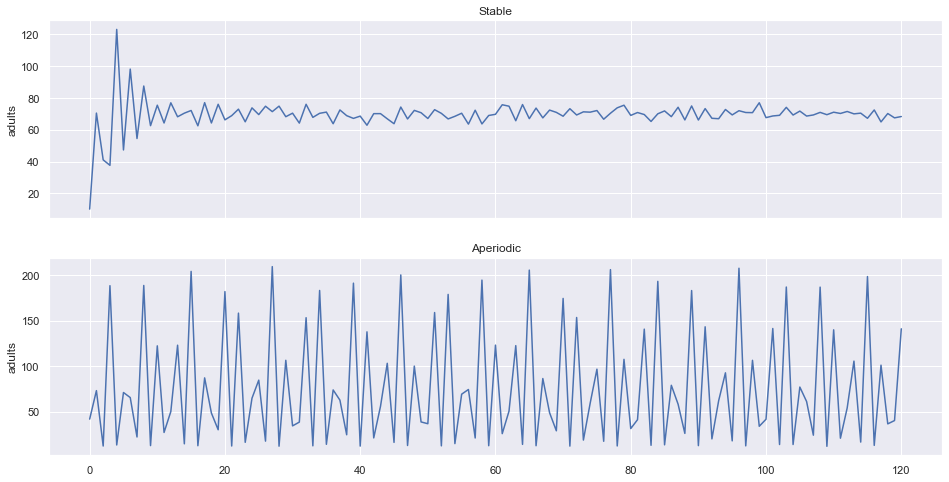

In [9]:
plot_time_series(data=data, series_id=42, n_steps=n_steps)

Evidently there is a clear visual difference between the stable and aperiodic behaviours - let's see if we can cluster the time series using TDA features with traditional clustering algorithms!

# Clustering

## Generate labels

First we generate the labels for the two different time series ($1$ for aperiodic, $0$ for stable) and split the data into train and test set.

In [10]:
y_true = np.repeat([1, 0], n_series)

id_train, id_test, y_train, y_test = train_test_split(
    range(2 * n_series), y_true, train_size=0.7, random_state=0
)

## Naive approach

As a simple baseline, we take the raw time series data describing the adult popultation of _Tribolium_ flour beetle and use <a href="https://scikit-learn.org/stable/modules/clustering.html#k-means">k-means</a> to cluster it. To measure the performance, we calculate the [homogeneity score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html). This score is useful to check whether the clusters only samples belonging to a single class and takes values in the range [0,1], where low values indicate low homogeneity.

In [11]:
X_naive = data["adults"].values.reshape((2 * n_series, -1))
fit_and_score_model(X_naive, y_train, y_test, id_train, id_test)

Homogeneity score (training): 0.42029944862990926
Homogeneity score (test): 0.43107891041790375


As we can see from the scores, using only the raw time series does not provide a satisfying clustering. Let's turn to TDA next to try to improve the performance!

## TDA Approach

As explained in the accompanying blog post, applying TDA to time series involves several steps that are summarised here:

1. Embed the time series using <a href="https://docs.giotto.ai/generated/giotto.time_series.TakensEmbedding.html#giotto.time_series.TakensEmbedding">Takens' embedding</a> into a higher dimensional space. 
2. Use the <a href="https://docs.giotto.ai/generated/giotto.homology.VietorisRipsPersistence.html#giotto.homology.VietorisRipsPersistence">Vietoris-Rips filtration</a> to calculate the persistence diagrams.
3. Scale and filter the diagrams.

These steps can be conveniently combined via the `Pipeline` [class](https://docs.giotto.ai/generated/giotto.pipeline.Pipeline.html#giotto.pipeline.Pipeline) from `giotto-learn`.

### Configuration parameters for pipeline

In [12]:
parameters_type = "fixed"
embedding_dimension = 2
embedding_time_delay = 3
n_jobs = 1

window_width = X_naive.shape[1] - ((embedding_dimension - 1) * embedding_time_delay + 1)
window_stride = 1

metric = "euclidean"
max_edge_length = 10
homology_dimensions = [0, 1]

epsilon = 0.0

### Define pipeline

In [13]:
steps = [
    (
        "embedding",
        ts.TakensEmbedding(
            parameters_type=parameters_type,
            dimension=embedding_dimension,
            time_delay=embedding_time_delay,
            n_jobs=n_jobs,
        ),
    ),
    ("window", ts.SlidingWindow(width=window_width, stride=1)),
    (
        "diagrams",
        hl.VietorisRipsPersistence(
            metric=metric,
            max_edge_length=max_edge_length,
            homology_dimensions=homology_dimensions,
            n_jobs=n_jobs,
        ),
    ),
    ("diagrams_scaler", diag.Scaler()),
    ("diagrams_filter", diag.Filtering(epsilon=epsilon)),
]

pipeline = Pipeline(steps)

### Run pipeline
Let's group the time series data in terms of stable vs. aperiodic and calculate the persistence diagrams associated with each one. Since we have 200 times series per group, we expect 400 persistence diagrams.

In [14]:
grouped_data = data.groupby(['type', 'series_id'])

In [15]:
X_filtered = []
for name, _ in progress_bar(grouped_data):
    X_filtered.append(
        pipeline.fit_transform(grouped_data.get_group(name)["adults"].values)
    )

In [16]:
# number of diagrams should be 400
len(X_filtered)

400

### Plot the persistence diagram
Next let's plot two persistence diagrams, one from the stable case, another from the aperiodic

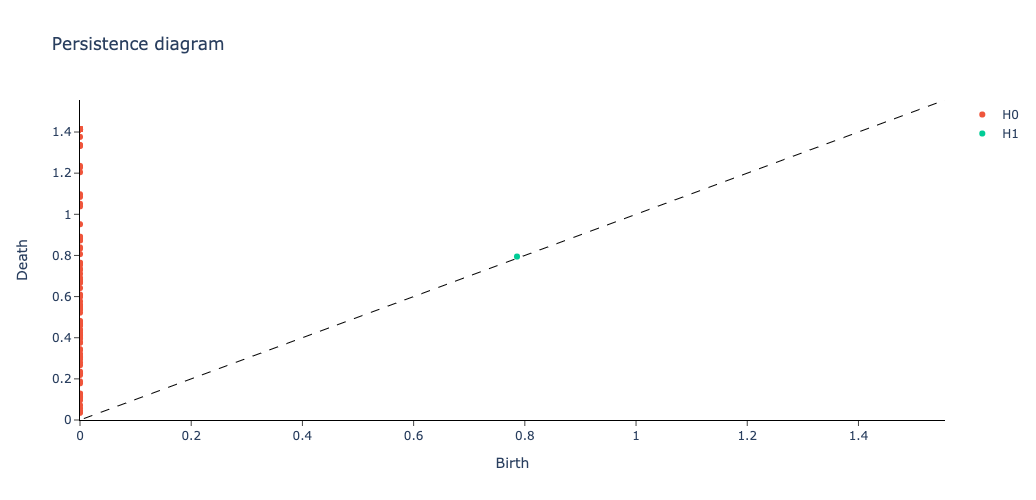

In [17]:
# stable diagram
plot_diagram(X_filtered[0][0])

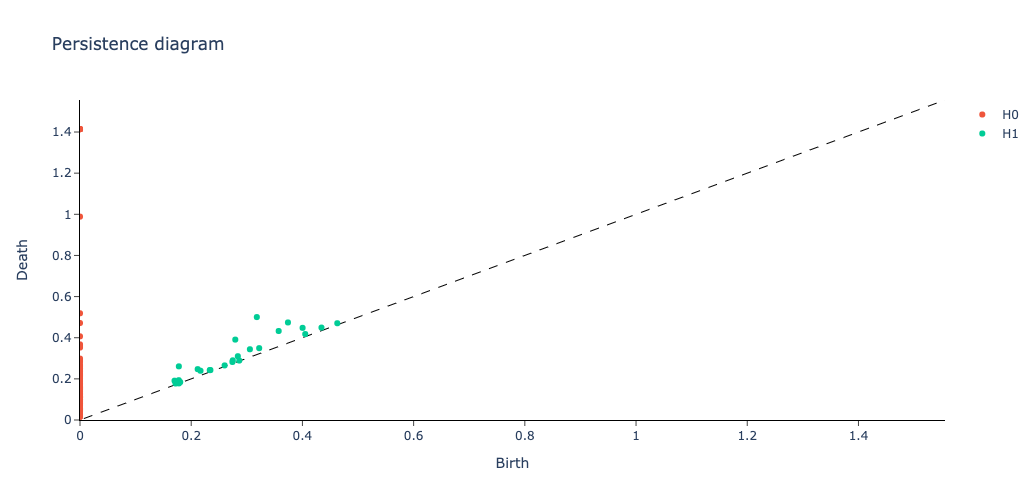

In [18]:
# aperiodic diagram
plot_diagram(X_filtered[-1][0])

### Functions for Feature Creation

Looking at persistence diagrams of our two cases, we see some differences. To capture these, we decide to calculate:
1. The mean lifetime of the holes per dimension
2. The number of holes per dimension
3. The number of holes that "survive" longer than a given threshold. We choose it as a fraction of the maximum lifetime of holes in the dimension,
4. The maximum lifetime of the holes per dimension
5. The amplitude of the diagram

We have implemented these functions in `features.py` to extract these features from the persistence diagram.

### TDA feature creation

We run the pipeline for each time series and create the corresponding features

In [19]:
# threshold to determine whether a hole is relevant or not
frac = 0.7

In [20]:
features = []
for name, _ in progress_bar(grouped_data):
    X_filtered = pipeline.fit_transform(grouped_data.get_group(name)["adults"].values)
    n_windows, n_points, _ = X_filtered.shape

    features.append(
        get_mean_lifetime(X_filtered, n_windows, n_points)
        + get_n_rel_holes(X_filtered, n_windows, n_points, frac=frac)
        + get_n_rel_holes(X_filtered, n_windows, n_points, frac=0.0)
        + get_max_lifetime(X_filtered, n_windows, n_points)
        + get_amplitude(X_filtered)
    )

### Clustering

Finally we perform clustering with the TDA features and calculate the homogeneity scores:

In [21]:
X_tda = np.array(features)
fit_and_score_model(X_tda, y_train, y_test, id_train, id_test)

Homogeneity score (training): 0.9692483881602528
Homogeneity score (test): 0.9391555049212249


It works! We see that compared with the our baseline clustering approach, the TDA features have provided a dramatic boost in enabling the clustering algorithm to distinguish between the two stable and aperiodic dynamics.

# Effect of noise on performance

In the analysis above, the effect of environmental noise was held fixed. Here we examine how the performance changes when increase the noise. The script below takes approximately 30 minutes to run on a modern laptop, so for convenience we provide the pre-generated data and performance metrics.

In [22]:
# uncomment to generate data from scratch
# %run beetles_tda/generate_data.py varying_noise \
#     --n_steps {n_steps} --n_series {n_series} \
#     --args_stable '{args_stable}' --args_aperiodic '{args_aperiodic}'

## Load pre-generated data and performance metrics

In [23]:
with open('models/performance_metrics_train.pkl', 'rb') as file:
    perf_train = pickle.load(file)

with open('models/performance_metrics_test.pkl', 'rb') as file:
    perf_test = pickle.load(file)

In [24]:
perf_train.head()

Type  Mean Standard Deviation of Noise     Score
0  Classic                               0.0  0.290024
1      TDA                               0.0  0.871667
2  Classic                               0.0  0.279401
3      TDA                               0.0  0.906232
4  Classic                               0.0  0.300826

In [25]:
perf_test.head()

Type  Mean Standard Deviation of Noise     Score
0  Classic                               0.0  0.295676
1      TDA                               0.0  0.937960
2  Classic                               0.0  0.282183
3      TDA                               0.0  0.832390
4  Classic                               0.0  0.323490

## Compare performance on train and test sets

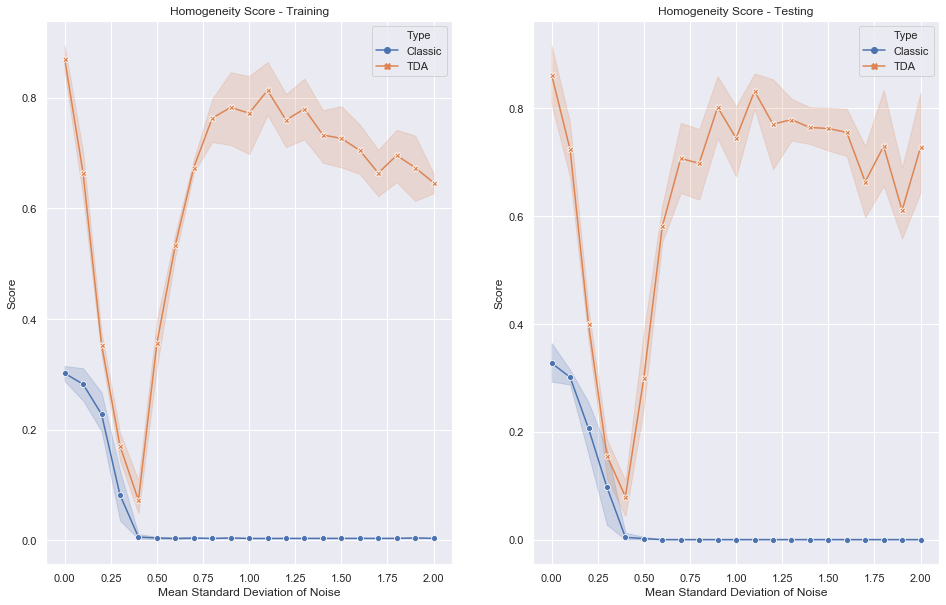

In [26]:
f, ax = plt.subplots(1, 2, figsize=(16,10))

(
    sns.lineplot(
        x="Mean Standard Deviation of Noise",
        y="Score",
        hue="Type",
        style="Type",
        markers=True,
        dashes=False,
        data=perf_train,
        ax=ax[0],
    ).set_title("Homogeneity Score - Training")
)
(
    sns.lineplot(
        x="Mean Standard Deviation of Noise",
        y="Score",
        hue="Type",
        style="Type",
        markers=True,
        dashes=False,
        data=perf_test,
        ax=ax[1],
    ).set_title("Homogeneity Score - Testing")
)
plt.show()

From the plots we that the TDA approach outperforms the naive one. Initially, the performance of both approaches decreases as the noise level increases. In particular, the naive approach completely fails to cluster the data for mean standard deviations larger than $0.4$. In contrast, the TDA approach performance increases above this point and is able to distinguish between the two types of time series, despite the fact that the noise tends to wash out the structure in the two types of series.

We can see this explicitly by visually comparing the two time series at different noise levels.

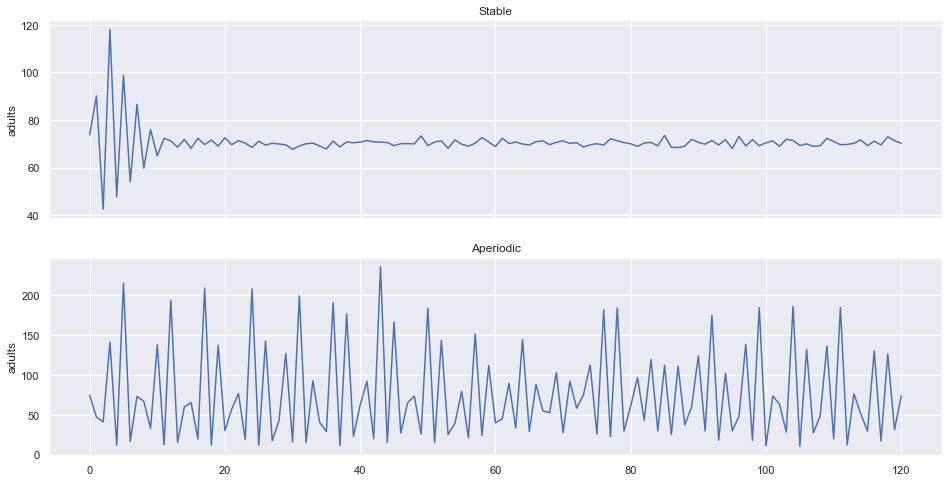

In [27]:
noise = .01
std = .01
data_low_noise = simulate_data(noise, std, n_steps, n_series, args_stable, args_aperiodic)

plot_time_series(data_low_noise, 0, n_steps)

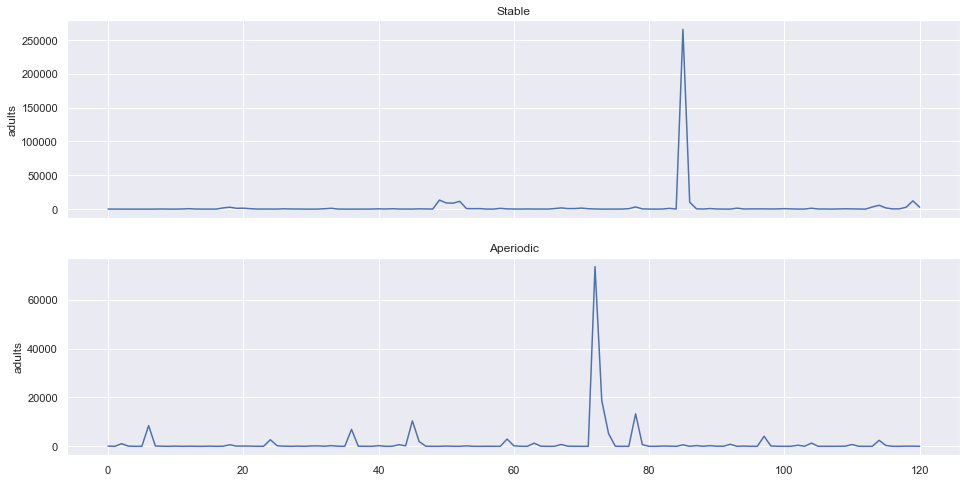

In [28]:
noise = 1.5
std = .01
data_high_noise = simulate_data(noise, std, n_steps, n_series, args_stable, args_aperiodic)

plot_time_series(data_high_noise, 0, n_steps)